# **Task2** : binary classification (no tumor, tumor)
With the same dataset and networks a binary classification is implemented, with the aim of studying and comparing the accuracy and the ROC curve in this easier situation respect to the one in task 1


Images are MRI scans from kaggle in jpg format organized in 4 folders, that represent the labels of the images.

Dataset: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/AI_exam_project

Mounted at /content/drive
/content/drive/MyDrive/AI_exam_project


In [ ]:
# Data augmentation parameters to improve the overfitting

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

In [24]:
from tqdm import tqdm

### Data preparation ###

train_dir = "archive-2/Training"
test_dir = "archive-2/Testing"

# Define the label mapping
label_mapping = {
    "no_tumor": 0,
    "meningioma_tumor": 1,
    "pituitary_tumor": 1,
    "glioma_tumor": 1
}

# Initialize lists to store image data and corresponding labels
train_images = []
train_labels = []
test_images = []
test_labels = []
original_labels = []

# Iterate over the subdirectories
for label in tqdm(os.listdir(train_dir)):
    # Get the directory path for the current label in the training directory
    train_label_dir = os.path.join(train_dir, label)

    # Get the directory path for the current label in the test directory
    test_label_dir = os.path.join(test_dir, label)

    # Determine the binary label for the current class
    binary_label = label_mapping.get(label, None)


    if binary_label is not None:
        # Iterate over the files in the training directory
        for filename in os.listdir(train_label_dir):
            # Get the path
            image_path = os.path.join(train_label_dir, filename)

            # Load the image
            image = load_img(image_path, target_size=(224, 224))

            # Convert the image to a numpy array
            image = img_to_array(image)

            if np.max(image)>255:
              print("valore maggiore di 255", np.max(image))

            image = image / 255.0

            # Append the image and label
            train_images.append(image)
            train_labels.append(binary_label)

        # Iterate over the files in the test directory
        for filename in os.listdir(test_label_dir):
            # Get the path
            image_path = os.path.join(test_label_dir, filename)

            # Load the image
            image = load_img(image_path, target_size=(224, 224))

            # Convert in numpy array
            image = img_to_array(image)
            image = image / 255.0

            # Append the image and label
            test_images.append(image)
            test_labels.append(binary_label)

            original_labels.append(label)

# Convert to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)


100%|██████████| 4/4 [00:21<00:00,  5.44s/it]


# Model 1: MyCNN

In [ ]:
# Define the MyCNN model

modelMyCNN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
modelMyCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

# Fit the model with augmented data generator
modelMyCNN.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    steps_per_epoch=len(train_images) // batch_size,
    epochs=50,
    validation_data=(test_images, test_labels)
)


# Evaluate the model
test_loss, test_acc = modelMyCNN.evaluate(np.array(test_images), test_labels)
print("Test accuracy:", test_acc)

# Make predictions
predictions_MyCNN = modelMyCNN.predict(np.array(test_images))
predicted_labels_MyCNN = [1 if pred > 0.5 else 0 for pred in predictions_MyCNN]

# Print classification report
print(classification_report(test_labels, predicted_labels_MyCNN, target_names=["No Tumor", "Tumor"]))


Epoch 1/50
90/90 [==============================] - 48s 406ms/step - loss: 0.4169 - accuracy: 0.8607 - val_loss: 0.7828 - val_accuracy: 0.7335
Epoch 2/50
90/90 [==============================] - 37s 407ms/step - loss: 0.3189 - accuracy: 0.8831 - val_loss: 0.8629 - val_accuracy: 0.5381
Epoch 3/50
90/90 [==============================] - 34s 381ms/step - loss: 0.2549 - accuracy: 0.9076 - val_loss: 0.6318 - val_accuracy: 0.6726
Epoch 4/50
90/90 [==============================] - 34s 377ms/step - loss: 0.2135 - accuracy: 0.9209 - val_loss: 0.8894 - val_accuracy: 0.5076
Epoch 5/50
90/90 [==============================] - 36s 405ms/step - loss: 0.2221 - accuracy: 0.9178 - val_loss: 0.7936 - val_accuracy: 0.5736
Epoch 6/50
90/90 [==============================] - 34s 381ms/step - loss: 0.1796 - accuracy: 0.9307 - val_loss: 0.9701 - val_accuracy: 0.4746
Epoch 7/50
90/90 [==============================] - 36s 406ms/step - loss: 0.1606 - accuracy: 0.9332 - val_loss: 0.8581 - val_accuracy: 0.5584

In [ ]:
# Save the model

%cd Trained_models_tumor_classification
modelMyCNN.save('My_CNN_task2.keras')
%cd ..

/content/drive/MyDrive/AI_exam_project/Trained_models_tumor_classification
/content/drive/MyDrive/AI_exam_project


In [ ]:
# Import the model

%cd Trained_models_tumor_classification
modelMyCNN = tf.keras.models.load_model('My_CNN_task2.keras')
%cd ..

13/13 [==============================] - 0s 17ms/step


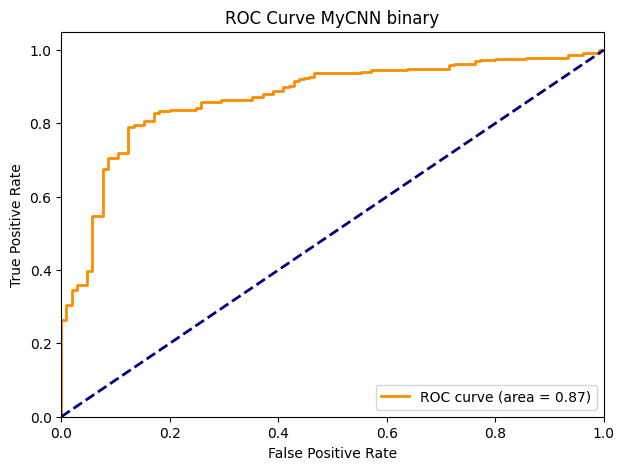

In [ ]:
# Make predictions for the positive class
predictions_MyCNN = modelMyCNN.predict(test_images)[:, 0]  # Get probabilities for the "Tumor" class

# Compute ROC curve and ROC area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(test_labels, predictions_MyCNN)
roc_auc = roc_auc_score(test_labels, predictions_MyCNN)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve MyCNN binary')
plt.legend(loc='lower right')
plt.show()

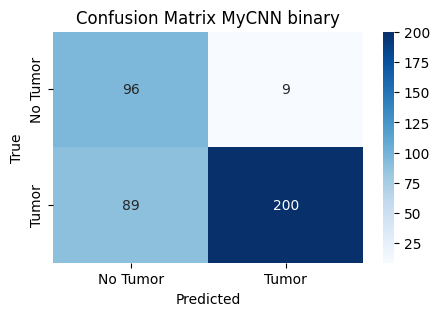

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels_MyCNN)

# Visualize the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix MyCNN binary')
plt.show()

# Model 2: MobileNetV2

In [ ]:
## MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

batch_size=32
steps_per_epoch=len(train_images) // batch_size


# Train the model
model.fit(
    datagen.flow(train_images, train_labels),
    epochs=50,
    validation_data=(test_images, test_labels)
)


# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy:", test_acc)


9406464/9406464 [==============================] - 2s 0us/step
Epoch 1/50
91/91 [==============================] - 44s 441ms/step - loss: 1.1437 - accuracy: 0.8948 - val_loss: 0.6781 - val_accuracy: 0.7995
Epoch 2/50
91/91 [==============================] - 39s 426ms/step - loss: 0.1392 - accuracy: 0.9522 - val_loss: 0.4918 - val_accuracy: 0.8325
Epoch 3/50
91/91 [==============================] - 35s 383ms/step - loss: 0.1283 - accuracy: 0.9561 - val_loss: 0.4729 - val_accuracy: 0.7132
Epoch 4/50
91/91 [==============================] - 37s 407ms/step - loss: 0.1174 - accuracy: 0.9581 - val_loss: 0.3512 - val_accuracy: 0.7970
Epoch 5/50
91/91 [==============================] - 35s 380ms/step - loss: 0.1110 - accuracy: 0.9616 - val_loss: 0.4168 - val_accuracy: 0.8325
Epoch 6/50
91/91 [==============================] - 37s 412ms/step - loss: 0.1019 - accuracy: 0.9602 - val_loss: 0.4760 - val_accuracy: 0.8477
Epoch 7/50
91/91 [==============================] - 37s 407ms/step - loss: 0.10

In [ ]:
# Save the model
%cd Trained_models_tumor_classification
#model.save('MobileNetV2_task2.keras')
%cd ..

/content/drive/MyDrive/AI_exam_project/Trained_models_tumor_classification
/content/drive/MyDrive/AI_exam_project


In [4]:
# Import the model
%cd Trained_models_tumor_classification
model = tf.keras.models.load_model('MobileNetV2_task2.keras')
%cd ..

/content/drive/MyDrive/AI_exam_project/Trained_models_tumor_classification
/content/drive/MyDrive/AI_exam_project


In [5]:
# Make predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print(classification_report(test_labels, predicted_labels, target_names=["No Tumor", "Tumor"]))

13/13 [==============================] - 17s 1s/step
              precision    recall  f1-score   support

    No Tumor       0.81      0.97      0.88       105
       Tumor       0.99      0.92      0.95       289

    accuracy                           0.93       394
   macro avg       0.90      0.94      0.92       394
weighted avg       0.94      0.93      0.93       394



13/13 [==============================] - 17s 1s/step


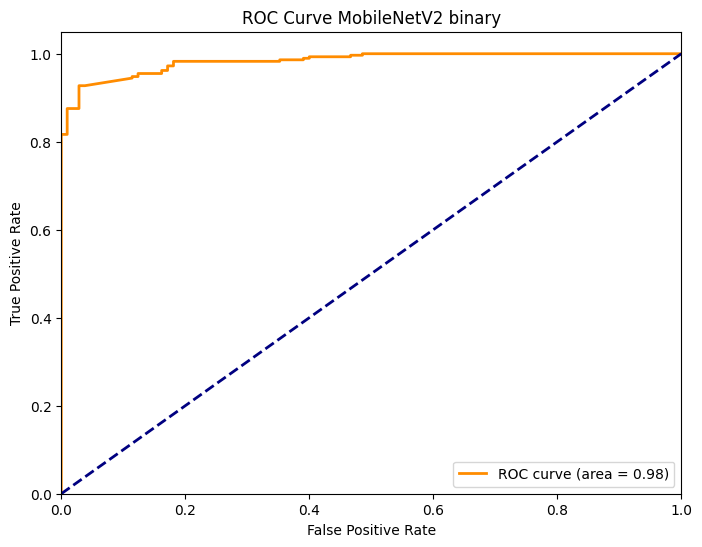

In [6]:
# Make predictions for the positive class
predictions = model.predict(test_images)[:, 1]

# Compute ROC curve and ROC area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(test_labels, predictions)
roc_auc = roc_auc_score(test_labels, predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve MobileNetV2 binary')
plt.legend(loc='lower right')
plt.show()


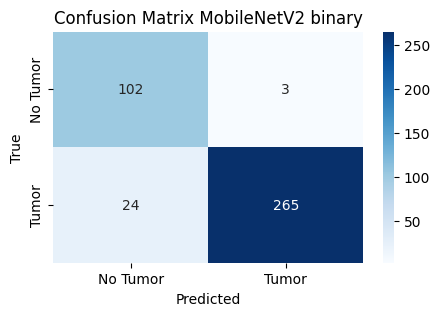

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix MobileNetV2 binary')
plt.show()

In [7]:
# Find the indices of false negatives
false_negative_indices = np.where((test_labels == 1) & (predicted_labels == 0))

original_labels = np.array(original_labels)
false_negatives = original_labels[false_negative_indices]

print("False Negative Indices:", false_negative_indices)
print("False Negatives:", false_negatives)


False Negative Indices: (array([125, 162, 191, 215, 222, 225, 232, 233, 236, 239, 242, 244, 260,
       265, 276, 287, 290, 303, 333, 360, 372, 384, 390, 391]),)
False Negatives: ['meningioma_tumor' 'meningioma_tumor' 'meningioma_tumor'
 'meningioma_tumor' 'glioma_tumor' 'glioma_tumor' 'glioma_tumor'
 'glioma_tumor' 'glioma_tumor' 'glioma_tumor' 'glioma_tumor'
 'glioma_tumor' 'glioma_tumor' 'glioma_tumor' 'glioma_tumor'
 'glioma_tumor' 'glioma_tumor' 'glioma_tumor' 'pituitary_tumor'
 'pituitary_tumor' 'pituitary_tumor' 'pituitary_tumor' 'pituitary_tumor'
 'pituitary_tumor']


In [25]:
#Open an image

for index in [125, 162, 191, 215, 222, 225, 232, 233, 236, 239, 242, 244, 260, 265, 276, 287, 290, 303, 333, 360, 372, 384, 390, 391]:
  image1 = test_images[index]
  label1 = original_labels[index]


# Plot the image with the corresponding label
  plt.imshow(image1)
  plt.title("Label: " + label1)
  plt.axis("off")
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

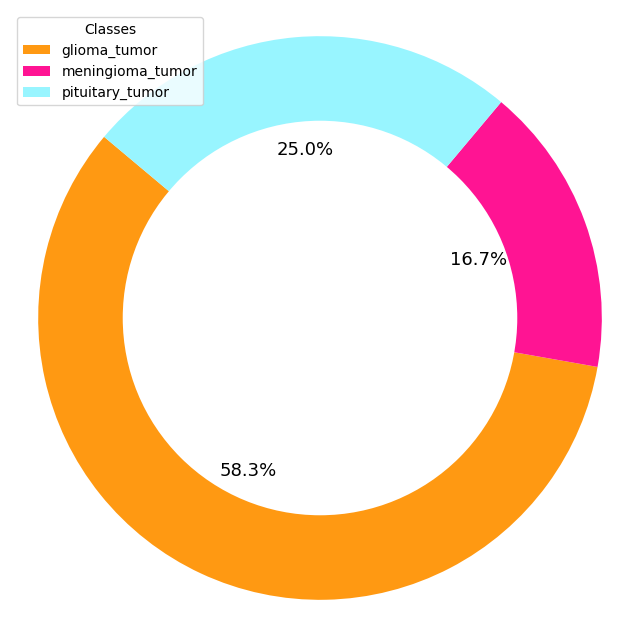

In [ ]:
#Count the number of unique false negatives and their occurrences
unique_false_negatives, counts = np.unique(false_negatives, return_counts=True)

# Create labels for the pie chart
labels = unique_false_negatives
sizes = counts
colors = ["#FF9912",  '#FF1493', '#98F5FF']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes,  autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 13})
plt.axis('equal')
plt.legend(labels, title="Classes", loc="best")
### Add a hole in the pie
hole = plt.Circle((0, 0), 0.70, facecolor='white')
plt.gcf().gca().add_artist(hole)

plt.show()